### Imports for Model

In [27]:
import numpy as np
import pandas as pd
from matplotlib import pylab as plt
from IPython import display
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

DATOS_DIR = "data/"
import os
import requests
from datetime import date, datetime, timedelta

# Asegurar carpeta de datos
os.makedirs(DATOS_DIR, exist_ok=True)

# Parámetros de periodo: primer día de marzo 2025 hasta hoy
START_DATE = "2025-03-10"
END_DATE = date.today().isoformat()

# Ruta local para guardar el CSV crudo
raw_csv_path = os.path.join(DATOS_DIR, 'training.csv')

# URL remota a consultar
remote_url = f"http://localhost:8080/?start={START_DATE}&end={END_DATE}"

# Flags: forzar descarga o re-procesado (poner True para forzar)
FORCE_DOWNLOAD = False
FORCE_REPROCESS = False

if FORCE_DOWNLOAD and os.path.exists(raw_csv_path):
    os.remove(raw_csv_path)

print("remote_url: ", remote_url)

if not os.path.exists(raw_csv_path):
    print(f"Descargando datos de {remote_url} ...")
    try:
        resp = requests.get(remote_url, timeout=30)
        resp.raise_for_status()
        with open(raw_csv_path, 'wb') as f:
            f.write(resp.content)
        print(f"Guardado CSV en {raw_csv_path}")
    except Exception as e:
        print("Error descargando datos desde localhost:", e)
        raise
else:
    print(f"Archivo CSV crudo ya existe en {raw_csv_path}")

data = pd.read_csv(raw_csv_path)

remote_url:  http://localhost:8080/?start=2025-03-10&end=2025-11-01
Archivo CSV crudo ya existe en data/training.csv


### Preprocessing 

In [28]:
def expand_datetime_column(data: pd.DataFrame) -> pd.DataFrame:
    """Convierte la primera columna de timestamps en columnas separadas (month, day, hour, minute)
    y genera una columna 'daylight' según sunrise/sunset."""
    data = data.copy()

    # Convertir la primera columna a datetime UTC
    col0 = data.columns[0]

    if data[col0].isna().any():
        print("⚠️ Algunas fechas no se pudieron convertir correctamente.")

    data[col0] = pd.to_datetime(data[col0], utc=True, errors="coerce")

    print(data[col0][0:5])

    # --- Cálculo de "daylight" ---
    # sunrise y sunset están en epoch unix UTC, por lo tanto convertimos también:
    data["sunrise_dt"] = pd.to_datetime(data["sunrise"], unit="s", utc=True)
    data["sunset_dt"]  = pd.to_datetime(data["sunset"],  unit="s", utc=True)

    print(data["sunrise_dt"][0:5])
    print(data["sunset_dt"][0:5])

    # Determinar si hay luz solar (1 si entre sunrise y sunset)
    data["daylight"] = (
        (data[col0] >= data["sunrise_dt"]) &
        (data[col0] <= data["sunset_dt"])
    ).astype(int)

    # Crear columnas separadas de tiempo
    data["month"]  = data[col0].dt.month
    data["day"]    = data[col0].dt.day
    data["hour"]   = data[col0].dt.hour
    data["minute"] = data[col0].dt.minute

    # Eliminar columnas auxiliares
    data = data.drop(columns=[col0, "sunrise_dt", "sunset_dt"])

    return data

data = expand_datetime_column(data)

# Convertir viento a componentes vectoriales
data["wind_x"] = data["wind_speed"] * np.cos(np.deg2rad(data["wind_direction"]))
data["wind_y"] = data["wind_speed"] * np.sin(np.deg2rad(data["wind_direction"]))
data = data.drop(columns=["wind_direction", "wind_speed"])

# Booleanos a enteros
data["working_day"] = data["working_day"].astype(int)
data["holiday"] = data["holiday"].astype(int)

# Separar features y labels
X = data.drop(columns=["consumption"])
T = data["consumption"]

data['daylight'].value_counts()

0   2025-03-10 03:00:00+00:00
1   2025-03-10 03:05:00+00:00
2   2025-03-10 03:10:00+00:00
3   2025-03-10 03:15:00+00:00
4   2025-03-10 03:20:00+00:00
Name: date, dtype: datetime64[ns, UTC]
0   2025-03-10 09:45:51+00:00
1   2025-03-10 09:45:51+00:00
2   2025-03-10 09:45:51+00:00
3   2025-03-10 09:45:51+00:00
4   2025-03-10 09:45:51+00:00
Name: sunrise_dt, dtype: datetime64[ns, UTC]
0   2025-03-10 22:18:04+00:00
1   2025-03-10 22:18:04+00:00
2   2025-03-10 22:18:04+00:00
3   2025-03-10 22:18:04+00:00
4   2025-03-10 22:18:04+00:00
Name: sunset_dt, dtype: datetime64[ns, UTC]


daylight
1    31727
0    27912
Name: count, dtype: int64

In [29]:
# Normalización Z-score
x_scaler = StandardScaler()
X_scaled = x_scaler.fit_transform(X)

# Escalar también la variable objetivo
y_scaler = StandardScaler()
T_scaled = y_scaler.fit_transform(T.values.reshape(-1, 1))


# División train-test
X_train, X_test, T_train, T_test = train_test_split(
    X_scaled, T_scaled, test_size=0.2, random_state=42
)


### Model

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers

model = Sequential([
    Dense(12, activation='relu', input_dim=X_train.shape[1]),
    Dense(8, activation='relu'),
    Dense(1, activation='linear')  # salida lineal para regresión
])

optimizer = optimizers.Adam(learning_rate=0.001)  # mucho más eficiente que SGD

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model.summary()


/home/gblas/Developer/STR/venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 12)             │           216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329 (1.29 KB)

 Trainable params: 329 (1.29 KB)

 Non-trainable params: 0 (0.00 B)

### Training

In [31]:
es = EarlyStopping(monitor='val_loss', patience=30, min_delta=0.0001)


history = model.fit(X_train, T_train,batch_size=64,
                    epochs=800,
                    verbose=0,  # cambiar a 1 si querés ver la salida
                    validation_data=(X_test, T_test),callbacks=[es])

# Guardar modelo
model.save('models/energy_consumption_model.h5')

### Evaluation

373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
Loss de test: 0.0385, Métrica: 0.1513
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step


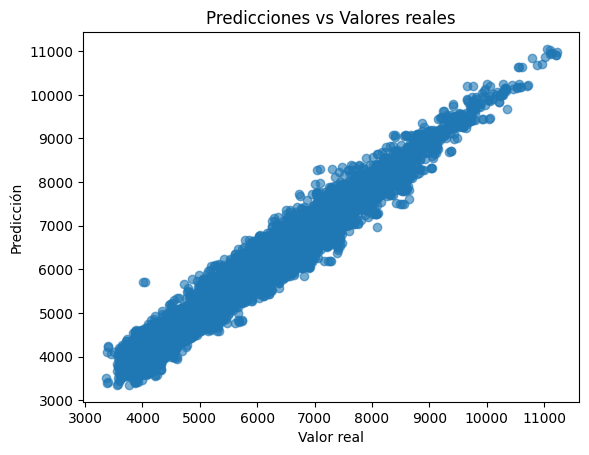

In [32]:
pred_scaled = model.predict(X_test)
pred = y_scaler.inverse_transform(pred_scaled)
T_real = y_scaler.inverse_transform(T_test)


# Evaluación del modelo
loss, metric = model.evaluate(X_test, T_test, verbose=0)
print(f"Loss de test: {loss:.4f}, Métrica: {metric:.4f}")

# Predicciones
y_pred = model.predict(X_test)

plt.scatter(T_real, pred, alpha=0.6)
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title("Predicciones vs Valores reales")
plt.show()


